# Time Series Forecasting Model using Machine Learning ⏱
The purpose of this notebook is to create a Time_series Forecast Model which could predict the Pull/Call for the given dataset.



Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.
More specifically, we'll look at the following topics.

* **Exploratory data analysis (EDA)** - the process of going through a dataset and finding out more about it.
* **Model training** - create model(s) to learn to predict a target variable based on other variables.
* **Model evaluation** - evaluating a models predictions using problem-specific evaluation metrics. 
* **Cross-validation** - if we do build a good model, can we be sure it will work on unseen data?
* **Predicting the Test Data** - We now finally, predict the target using out trained model and the test data.
* **Plotting the Aquired Values** - We can visually validate the predicted values by seeing the trends on the plot

## 1. Importing required packages

In [1]:
# Regular EDA and plotting libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError
import datetime
from math import *

#To get rid of warnings
import warnings
warnings.filterwarnings("ignore")

# We want our plots to appear in the notebook
%matplotlib inline

## Models
from statsmodels.tsa.vector_ar.var_model import VAR

## Model evaluators
from sklearn.metrics import mean_squared_error

## 2. Data Exploration

Data can be found in `Data/` Folder. 
The ones we are going to use:
* `Test_dataset - Put-Call_TS.csv`


Once we have imported our data, we are going to explore and get to know about the different Attributes and their patterns with the data.

Data Exploration is one of most important tasks in Machine Learning.

We edited the given raw .xlsx file as it wasn't oraganized properly for `pandas` to read it.

Because of this issue the imported data would have `Object` as dtype instead `int64`.

**Note :** We havent manuplated data outside the notebook. You can cross verify with the .csv file

In [2]:
# Importing the Data
data = pd.read_csv("data/Test_dataset - Put-Call_TS.csv")

### 2.1 Minor Changes to the Index of the Data
There is a seperate column for `Stock Data` which is set as default index and the column is dropped.

In [3]:
data.index = data["Stock Index"] #Stock Index Column is set as default Index

data.drop('Stock Index',inplace=True, axis=1) 
# As this column is set as default index, we no lomger require this column
data

,10-Aug,11-Aug,12-Aug,13-Aug,14-Aug,15-Aug
Stock Index,,,,,,
AC3235,0.80,0.660,0.77240,0.983224,0.901211,0.898368
AC3236,0.86,0.732,0.85448,1.086645,1.017042,1.029258
AC3237,0.93,0.816,0.95024,1.207302,NaN,1.181962
AC3238,1.09,1.008,1.16912,1.483091,1.461062,1.531000
AC3239,NaN,1.104,1.27856,1.620986,1.615504,1.705519
...,...,...,...,...,...,...
AD2734,0.86,0.732,0.85448,1.086645,1.017042,1.029258
AD2735,0.64,0.468,0.55352,0.707435,0.592327,0.549330
AD2736,0.67,0.504,0.59456,0.759146,0.650243,0.614775


In [4]:
data.info() #Gives Insight about different Attributes

<class 'pandas.core.frame.DataFrame'>
Index: 3331 entries, AC3235 to AD2738
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   10-Aug  2902 non-null   float64
 1   11-Aug  3329 non-null   float64
 2   12-Aug  3274 non-null   float64
 3   13-Aug  3317 non-null   float64
 4   14-Aug  3226 non-null   float64
 5   15-Aug  3092 non-null   float64
dtypes: float64(6)
memory usage: 182.2+ KB


### 2.2 Filling Missing Values
Here we are using `pd.interpolate()` because that is optimal way of filling the missing values in a Time-Series DataSet. We could also fill with the `mean()` but in our case `pd.interpolate()` would work the best as the Columns and Rows are linearly depended too.


In [5]:
data.isna().sum() # Returns count of missing values

10-Aug    429
11-Aug      2
12-Aug     57
13-Aug     14
14-Aug    105
15-Aug    239
dtype: int64

In [6]:
data = data.interpolate() # To fill Missing Values

In [7]:
data.isna().sum() # All the missing are Handled

10-Aug    0
11-Aug    0
12-Aug    0
13-Aug    0
14-Aug    0
15-Aug    0
dtype: int64

In [8]:
data = data.T # Transposing the Data 
data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
10-Aug,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
11-Aug,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
12-Aug,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
13-Aug,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
14-Aug,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
15-Aug,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479


### 2.3 Parsing Indexes in DateTime Format
As this is Time-Series Problem its best to have `DateTime Object` as our indexes

In [9]:
data.index=pd.date_range("8/10/2020", freq="D", periods=6)
data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
2020-08-15,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479


### 2.4 Splitting the Data
The Data should be splitted into **train** and **test** .

* **Train** Data is used to train the model.

* **Test** Data is used to evaluate the model.

In [10]:
train = data[:int(0.9*(len(data)))]
valid = data[int(0.9*(len(data))):]

In [11]:
train #Data from Aug 10th to Aug 14th

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380


In [12]:
valid #Data on Aug 15th

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-15,0.898368,1.029258,1.181962,1.531,1.705519,1.792779,1.836409,1.334666,1.334666,1.48737,...,1.029258,0.46207,0.789294,1.312851,1.356481,1.029258,0.54933,0.614775,0.876553,0.767479


## 3. Training Our Model
We've explored the data, now we'll try to use machine learning to predict our target variable

Best Algorithm for this problem is : **VAR** : Vector Autoregression is most commonly used methods for multivariate time series forecasting.



In [13]:
# Training our model using Trained Data
model = VAR(endog=train)
model_fit = model.fit()
model_fit.y

array([[0.8       , 0.86      , 0.93      , ..., 0.67      , 0.79      ,
        0.74      ],
       [0.66      , 0.732     , 0.816     , ..., 0.504     , 0.648     ,
        0.588     ],
       [0.7724    , 0.85448   , 0.95024   , ..., 0.59456   , 0.75872   ,
        0.69032   ],
       [0.983224  , 1.0866448 , 1.2073024 , ..., 0.7591456 , 0.9659872 ,
        0.8798032 ],
       [0.90121088, 1.01704218, 1.23905216, ..., 0.65024307, 0.88190566,
        0.78537958]])

In [14]:
cols = data.columns

prediction = model_fit.forecast(model_fit.endog, steps=len(valid))
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])

# For loop to append all the predictions to a DataFrame : pred
for j in range(0,3331):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [15]:
pred.index = [datetime.datetime(2020, 8, 15)]
pred.T #These are the values predicted by the for August 15th

,2020-08-15
Stock Index,
AC3235,1.01983
AC3236,1.138537
AC3237,1.323383
AC3238,1.593582
AC3239,1.751858
...,...
AD2734,1.138537
AD2735,0.703277
AD2736,0.76263


## 4. Model Evaluation
Our model has just predicted the values for August 15th. We will be comparing these value with valid values. 

### Root Mean Square Error
The **root-mean-square error (RMSE)** is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed.

The below for loop will output RMSE Value for each Stock. And all the values are nearer to zero as they should be.

In [16]:
# The below for loop will output RMSE Value for each Stock(3331 Stocks). 
# And all the values are nearer to zero as they should be.

for i in cols:
    print('RMSE Value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

RMSE Value for AC3235 is :  0.12146140913346959
RMSE Value for AC3236 is :  0.109279409285993
RMSE Value for AC3237 is :  0.14142062572883374
RMSE Value for AC3238 is :  0.06258174503735603
RMSE Value for AC3239 is :  0.04633907990739461
RMSE Value for AC3240 is :  0.03821774634241115
RMSE Value for AC3241 is :  0.034157080059919354
RMSE Value for AC3242 is :  0.08085474430855588
RMSE Value for AC3243 is :  0.08085474430855588
RMSE Value for AC3244 is :  0.05532088785756417
RMSE Value for AC3245 is :  0.07476374488482307
RMSE Value for AC3246 is :  0.10521874300350809
RMSE Value for AC3247 is :  0.13973440740467602
RMSE Value for AC3248 is :  0.16343189356205157
RMSE Value for AC3249 is :  0.16700768016669865
RMSE Value for AC3250 is :  0.1580074066758801
RMSE Value for AC3251 is :  0.1458254078284149
RMSE Value for AC3252 is :  0.06258174503735603
RMSE Value for AC3253 is :  0.1559770735346392
RMSE Value for AC3254 is :  0.07679407802607474
RMSE Value for AC3255 is :  0.05852107875485

RMSE Value for AC3473 is :  0.2026080164758588
RMSE Value for AC3474 is :  0.3780530269836706
RMSE Value for AC3475 is :  0.28221335849649376
RMSE Value for AC3476 is :  0.07257986630407509
RMSE Value for AC3477 is :  0.2755008487460019
RMSE Value for AC3478 is :  0.10395461941774387
RMSE Value for AC3479 is :  0.17513204454174258
RMSE Value for AC3480 is :  0.270971712028905
RMSE Value for AC3481 is :  0.24974470756342426
RMSE Value for AC3482 is :  0.5361698142055487
RMSE Value for AC3483 is :  0.19370771108656903
RMSE Value for AC3484 is :  0.1734166363955847
RMSE Value for AC3485 is :  0.4089553926047076
RMSE Value for AC3486 is :  0.09381129337494443
RMSE Value for AC3487 is :  0.1556204472224061
RMSE Value for AC3488 is :  0.19542311923272138
RMSE Value for AC3489 is :  0.06072113211512198
RMSE Value for AC3490 is :  0.21821640901024475
RMSE Value for AC3491 is :  0.30250001058209686
RMSE Value for AC3492 is :  0.009362394189472045
RMSE Value for AC3493 is :  0.19713852737888082


RMSE Value for AC3655 is :  0.1417647405459238
RMSE Value for AC3656 is :  0.12755240855720162
RMSE Value for AC3657 is :  0.07070307860233349
RMSE Value for AC3658 is :  0.06461207817859838
RMSE Value for AC3659 is :  0.04227841262490628
RMSE Value for AC3660 is :  0.15191640725214584
RMSE Value for AC3661 is :  0.10521874300350809
RMSE Value for AC3662 is :  0.05243007933113142
RMSE Value for AC3663 is :  0.09912774357977261
RMSE Value for AC3664 is :  0.0443087467661516
RMSE Value for AC3665 is :  0.08694574373229758
RMSE Value for AC3666 is :  0.06867274546108915
RMSE Value for AC3667 is :  0.14785574096965393
RMSE Value for AC3668 is :  0.03009641377742933
RMSE Value for AC3669 is :  0.1316130748396901
RMSE Value for AC3670 is :  0.16206807295837017
RMSE Value for AC3671 is :  0.09303674315602972
RMSE Value for AC3672 is :  0.1559770735346392
RMSE Value for AC3673 is :  0.14379507368716515
RMSE Value for AC3674 is :  0.04227841262490628
RMSE Value for AC3675 is :  0.02400541435369

RMSE Value for AD88 is :  0.16206807295837017
RMSE Value for AD89 is :  0.024005414353693855
RMSE Value for AD90 is :  0.08897607687354236
RMSE Value for AD91 is :  0.09100641001478782
RMSE Value for AD92 is :  0.028066080636178325
RMSE Value for AD93 is :  0.06258174503735603
RMSE Value for AD94 is :  0.07070307860233349
RMSE Value for AD95 is :  0.16206807295837017
RMSE Value for AD96 is :  0.034157080059919354
RMSE Value for AD97 is :  0.13770407426342834
RMSE Value for AD98 is :  0.15191640725214584
RMSE Value for AD99 is :  0.14379507368716515
RMSE Value for AD100 is :  0.0443087467661516
RMSE Value for AD101 is :  0.03618741320116037
RMSE Value for AD102 is :  0.04227841262490628
RMSE Value for AD103 is :  0.048369413048634735
RMSE Value for AD104 is :  0.06258174503735603
RMSE Value for AD105 is :  0.06055141189610924
RMSE Value for AD106 is :  0.09506707729727637
RMSE Value for AD107 is :  0.12349174227471205
RMSE Value for AD108 is :  0.08491541059105168
RMSE Value for AD109 i

RMSE Value for AD269 is :  0.08897607687354236
RMSE Value for AD270 is :  0.06664241131984405
RMSE Value for AD271 is :  0.16206807295837017
RMSE Value for AD272 is :  0.028066080636178325
RMSE Value for AD273 is :  0.11130974242723912
RMSE Value for AD274 is :  0.10724907614475243
RMSE Value for AD275 is :  0.04024807948365838
RMSE Value for AD276 is :  0.109279409285993
RMSE Value for AD277 is :  0.13973440740467602
RMSE Value for AD278 is :  0.07679407802607474
RMSE Value for AD279 is :  0.12349174227471205
RMSE Value for AD280 is :  0.03009641377742933
RMSE Value for AD281 is :  0.028066080636178325
RMSE Value for AD282 is :  0.10115807672101096
RMSE Value for AD283 is :  0.1174007418509776
RMSE Value for AD284 is :  0.12755240855720162
RMSE Value for AD285 is :  0.12146140913346959
RMSE Value for AD286 is :  0.13567374112218322
RMSE Value for AD287 is :  0.1174007418509776
RMSE Value for AD288 is :  0.10318840986225974
RMSE Value for AD289 is :  0.12349174227471205
RMSE Value for 

RMSE Value for AD459 is :  0.463313558017739
RMSE Value for AD460 is :  0.5818188039022401
RMSE Value for AD461 is :  0.4200929534381874
RMSE Value for AD462 is :  0.040736933527824704
RMSE Value for AD463 is :  0.4968955732525683
RMSE Value for AD464 is :  0.3816375716940562
RMSE Value for AD465 is :  0.5433634221581105
RMSE Value for AD466 is :  0.4874591031758586
RMSE Value for AD467 is :  0.6170269413203875
RMSE Value for AD468 is :  0.6130651955164277
RMSE Value for AD469 is :  0.5112054098385814
RMSE Value for AD470 is :  0.4088332419507896
RMSE Value for AD471 is :  0.5240912435092993
RMSE Value for AD472 is :  0.5675089673162304
RMSE Value for AD473 is :  0.596330759756285
RMSE Value for AD474 is :  0.3356821049984451
RMSE Value for AD475 is :  0.055248889381870114
RMSE Value for AD476 is :  0.091368647505359
RMSE Value for AD477 is :  0.4858329809925379
RMSE Value for AD478 is :  0.1529448099877262
RMSE Value for AD479 is :  0.23929704359334836
RMSE Value for AD480 is :  0.493

RMSE Value for AD645 is :  0.050399746189887074
RMSE Value for AD646 is :  0.1174007418509776
RMSE Value for AD647 is :  0.07679407802607474
RMSE Value for AD648 is :  0.12146140913346959
RMSE Value for AD649 is :  0.028066080636178325
RMSE Value for AD650 is :  0.15191640725214584
RMSE Value for AD651 is :  0.07679407802607474
RMSE Value for AD652 is :  0.08288507744980356
RMSE Value for AD653 is :  0.1417647405459238
RMSE Value for AD654 is :  0.1580074066758801
RMSE Value for AD655 is :  0.1417647405459238
RMSE Value for AD656 is :  0.05852107875485535
RMSE Value for AD657 is :  0.12552207541595428
RMSE Value for AD658 is :  0.034157080059919354
RMSE Value for AD659 is :  0.03009641377742933
RMSE Value for AD660 is :  0.07070307860233349
RMSE Value for AD661 is :  0.1559770735346392
RMSE Value for AD662 is :  0.04227841262490628
RMSE Value for AD663 is :  0.15394674039339162
RMSE Value for AD664 is :  0.03821774634241115
RMSE Value for AD665 is :  0.109279409285993
RMSE Value for AD

RMSE Value for AD826 is :  0.1174007418509776
RMSE Value for AD827 is :  0.048369413048634735
RMSE Value for AD828 is :  0.04024807948365838
RMSE Value for AD829 is :  0.12349174227471205
RMSE Value for AD830 is :  0.1133400755684878
RMSE Value for AD831 is :  0.1559770735346392
RMSE Value for AD832 is :  0.07476374488482307
RMSE Value for AD833 is :  0.09506707729727637
RMSE Value for AD834 is :  0.021975081212446845
RMSE Value for AD835 is :  0.160037739817127
RMSE Value for AD836 is :  0.09709741043852471
RMSE Value for AD837 is :  0.11130974242723912
RMSE Value for AD838 is :  0.0443087467661516
RMSE Value for AD839 is :  0.10318840986225974
RMSE Value for AD840 is :  0.10724907614475243
RMSE Value for AD841 is :  0.06258174503735603
RMSE Value for AD842 is :  0.06461207817859838
RMSE Value for AD843 is :  0.028066080636178325
RMSE Value for AD844 is :  0.08897607687354236
RMSE Value for AD845 is :  0.109279409285993
RMSE Value for AD846 is :  0.03009641377742933
RMSE Value for AD8

RMSE Value for AD1006 is :  0.16206807295837017
RMSE Value for AD1007 is :  0.12755240855720162
RMSE Value for AD1008 is :  0.024005414353693855
RMSE Value for AD1009 is :  0.10318840986225974
RMSE Value for AD1010 is :  0.05446041247237554
RMSE Value for AD1011 is :  0.03821774634241115
RMSE Value for AD1012 is :  0.16206807295837017
RMSE Value for AD1013 is :  0.06258174503735603
RMSE Value for AD1014 is :  0.07070307860233349
RMSE Value for AD1015 is :  0.14785574096965393
RMSE Value for AD1016 is :  0.12958274169844974
RMSE Value for AD1017 is :  0.09709741043852471
RMSE Value for AD1018 is :  0.07679407802607474
RMSE Value for AD1019 is :  0.04024807948365838
RMSE Value for AD1020 is :  0.1417647405459238
RMSE Value for AD1021 is :  0.06867274546108915
RMSE Value for AD1022 is :  0.03618741320116037
RMSE Value for AD1023 is :  0.06867274546108915
RMSE Value for AD1024 is :  0.133643407980939
RMSE Value for AD1025 is :  0.05243007933113142
RMSE Value for AD1026 is :  0.123491742274

RMSE Value for AD1193 is :  0.06258174503735603
RMSE Value for AD1194 is :  0.08897607687354236
RMSE Value for AD1195 is :  0.024005414353693855
RMSE Value for AD1196 is :  0.08694574373229758
RMSE Value for AD1197 is :  0.028066080636178325
RMSE Value for AD1198 is :  0.14988607411090227
RMSE Value for AD1199 is :  0.14988607411090227
RMSE Value for AD1200 is :  0.12958274169844974
RMSE Value for AD1201 is :  0.10115807672101096
RMSE Value for AD1202 is :  0.07070307860233349
RMSE Value for AD1203 is :  0.06867274546108915
RMSE Value for AD1204 is :  0.11130974242723912
RMSE Value for AD1205 is :  0.05243007933113142
RMSE Value for AD1206 is :  0.09100641001478782
RMSE Value for AD1207 is :  0.14379507368716515
RMSE Value for AD1208 is :  0.16206807295837017
RMSE Value for AD1209 is :  0.09506707729727637
RMSE Value for AD1210 is :  0.16206807295837017
RMSE Value for AD1211 is :  0.021975081212446845
RMSE Value for AD1212 is :  0.08694574373229758
RMSE Value for AD1213 is :  0.0402480

RMSE Value for AD1444 is :  0.07679407802607474
RMSE Value for AD1445 is :  0.1458254078284149
RMSE Value for AD1446 is :  0.10521874300350809
RMSE Value for AD1447 is :  0.07679407802607474
RMSE Value for AD1448 is :  0.1174007418509776
RMSE Value for AD1449 is :  0.10521874300350809
RMSE Value for AD1450 is :  0.09709741043852471
RMSE Value for AD1451 is :  0.133643407980939
RMSE Value for AD1452 is :  0.04024807948365838
RMSE Value for AD1453 is :  0.1316130748396901
RMSE Value for AD1454 is :  0.07882441116731154
RMSE Value for AD1455 is :  0.07070307860233349
RMSE Value for AD1456 is :  0.10724907614475243
RMSE Value for AD1457 is :  0.09912774357977261
RMSE Value for AD1458 is :  0.09100641001478782
RMSE Value for AD1459 is :  0.03821774634241115
RMSE Value for AD1460 is :  0.12552207541595428
RMSE Value for AD1461 is :  0.15394674039339162
RMSE Value for AD1462 is :  0.08694574373229758
RMSE Value for AD1463 is :  0.10318840986225974
RMSE Value for AD1464 is :  0.149886074110902

RMSE Value for AD1629 is :  0.034157080059919354
RMSE Value for AD1630 is :  0.026035747494939976
RMSE Value for AD1631 is :  0.04633907990739461
RMSE Value for AD1632 is :  0.04227841262490628
RMSE Value for AD1633 is :  0.12349174227471205
RMSE Value for AD1634 is :  0.11943107499222239
RMSE Value for AD1635 is :  0.12755240855720162
RMSE Value for AD1636 is :  0.14988607411090227
RMSE Value for AD1637 is :  0.1580074066758801
RMSE Value for AD1638 is :  0.07273341174358094
RMSE Value for AD1639 is :  0.04633907990739461
RMSE Value for AD1640 is :  0.16206807295837017
RMSE Value for AD1641 is :  0.03618741320116037
RMSE Value for AD1642 is :  0.09506707729727637
RMSE Value for AD1643 is :  0.034157080059919354
RMSE Value for AD1644 is :  0.04227841262490628
RMSE Value for AD1645 is :  0.133643407980939
RMSE Value for AD1646 is :  0.048369413048634735
RMSE Value for AD1647 is :  0.133643407980939
RMSE Value for AD1648 is :  0.034157080059919354
RMSE Value for AD1649 is :  0.0930367431

RMSE Value for AD1815 is :  0.05446041247237554
RMSE Value for AD1816 is :  0.11130974242723912
RMSE Value for AD1817 is :  0.10115807672101096
RMSE Value for AD1818 is :  0.11130974242723912
RMSE Value for AD1819 is :  0.15394674039339162
RMSE Value for AD1820 is :  0.109279409285993
RMSE Value for AD1821 is :  0.1316130748396901
RMSE Value for AD1822 is :  0.05852107875485535
RMSE Value for AD1823 is :  0.03618741320116037
RMSE Value for AD1824 is :  0.03618741320116037
RMSE Value for AD1825 is :  0.11130974242723912
RMSE Value for AD1826 is :  0.12552207541595428
RMSE Value for AD1827 is :  0.05243007933113142
RMSE Value for AD1828 is :  0.07273341174358094
RMSE Value for AD1829 is :  0.1417647405459238
RMSE Value for AD1830 is :  0.13973440740467602
RMSE Value for AD1831 is :  0.06867274546108915
RMSE Value for AD1832 is :  0.0443087467661516
RMSE Value for AD1833 is :  0.109279409285993
RMSE Value for AD1834 is :  0.1153704087097337
RMSE Value for AD1835 is :  0.1580074066758801
R

RMSE Value for AD2002 is :  0.07882441116731154
RMSE Value for AD2003 is :  0.11943107499222239
RMSE Value for AD2004 is :  0.12958274169844974
RMSE Value for AD2005 is :  0.14785574096965393
RMSE Value for AD2006 is :  0.08897607687354236
RMSE Value for AD2007 is :  0.06461207817859838
RMSE Value for AD2008 is :  0.06055141189610924
RMSE Value for AD2009 is :  0.021975081212446845
RMSE Value for AD2010 is :  0.028066080636178325
RMSE Value for AD2011 is :  0.14785574096965393
RMSE Value for AD2012 is :  0.12755240855720162
RMSE Value for AD2013 is :  0.08491541059105168
RMSE Value for AD2014 is :  0.15191640725214584
RMSE Value for AD2015 is :  0.16206807295837017
RMSE Value for AD2016 is :  0.16206807295837017
RMSE Value for AD2017 is :  0.05243007933113142
RMSE Value for AD2018 is :  0.048369413048634735
RMSE Value for AD2019 is :  0.021975081212446845
RMSE Value for AD2020 is :  0.08897607687354236
RMSE Value for AD2021 is :  0.09100641001478782
RMSE Value for AD2022 is :  0.107249

RMSE Value for AD2183 is :  0.1580074066758801
RMSE Value for AD2184 is :  0.133643407980939
RMSE Value for AD2185 is :  0.04227841262490628
RMSE Value for AD2186 is :  0.0443087467661516
RMSE Value for AD2187 is :  0.133643407980939
RMSE Value for AD2188 is :  0.05852107875485535
RMSE Value for AD2189 is :  0.11130974242723912
RMSE Value for AD2190 is :  0.12146140913346959
RMSE Value for AD2191 is :  0.028066080636178325
RMSE Value for AD2192 is :  0.1316130748396901
RMSE Value for AD2193 is :  0.04024807948365838
RMSE Value for AD2194 is :  0.15394674039339162
RMSE Value for AD2195 is :  0.06867274546108915
RMSE Value for AD2196 is :  0.09303674315602972
RMSE Value for AD2197 is :  0.03009641377742933
RMSE Value for AD2198 is :  0.13567374112218322
RMSE Value for AD2199 is :  0.07273341174358094
RMSE Value for AD2200 is :  0.16206807295837017
RMSE Value for AD2201 is :  0.10318840986225974
RMSE Value for AD2202 is :  0.08288507744980356
RMSE Value for AD2203 is :  0.1559770735346392

RMSE Value for AD2369 is :  0.1316130748396901
RMSE Value for AD2370 is :  0.1580074066758801
RMSE Value for AD2371 is :  0.06664241131984405
RMSE Value for AD2372 is :  0.10318840986225974
RMSE Value for AD2373 is :  0.034157080059919354
RMSE Value for AD2374 is :  0.08491541059105168
RMSE Value for AD2375 is :  0.08897607687354236
RMSE Value for AD2376 is :  0.109279409285993
RMSE Value for AD2377 is :  0.021975081212446845
RMSE Value for AD2378 is :  0.08288507744980356
RMSE Value for AD2379 is :  0.06461207817859838
RMSE Value for AD2380 is :  0.06461207817859838
RMSE Value for AD2381 is :  0.08694574373229758
RMSE Value for AD2382 is :  0.14379507368716515
RMSE Value for AD2383 is :  0.09100641001478782
RMSE Value for AD2384 is :  0.04227841262490628
RMSE Value for AD2385 is :  0.06664241131984405
RMSE Value for AD2386 is :  0.06461207817859838
RMSE Value for AD2387 is :  0.04227841262490628
RMSE Value for AD2388 is :  0.10724907614475243
RMSE Value for AD2389 is :  0.028066080636

RMSE Value for AD2555 is :  0.09506707729727637
RMSE Value for AD2556 is :  0.05852107875485535
RMSE Value for AD2557 is :  0.04227841262490628
RMSE Value for AD2558 is :  0.026035747494939976
RMSE Value for AD2559 is :  0.10115807672101096
RMSE Value for AD2560 is :  0.07882441116731154
RMSE Value for AD2561 is :  0.15394674039339162
RMSE Value for AD2562 is :  0.160037739817127
RMSE Value for AD2563 is :  0.08085474430855588
RMSE Value for AD2564 is :  0.08085474430855588
RMSE Value for AD2565 is :  0.04633907990739461
RMSE Value for AD2566 is :  0.07273341174358094
RMSE Value for AD2567 is :  0.15394674039339162
RMSE Value for AD2568 is :  0.05243007933113142
RMSE Value for AD2569 is :  0.07273341174358094
RMSE Value for AD2570 is :  0.12552207541595428
RMSE Value for AD2571 is :  0.15191640725214584
RMSE Value for AD2572 is :  0.1580074066758801
RMSE Value for AD2573 is :  0.133643407980939
RMSE Value for AD2574 is :  0.05446041247237554
RMSE Value for AD2575 is :  0.07679407802607

## 5. Predicting Pull-Call Value on August 16th

Now we are feeding our model complete data (from 10th Aug to 15th Aug) and it's gonna output or predictions for 16Th August

In [17]:
model = VAR(endog=data)
model_fit = model.fit()
aug16 = model_fit.forecast(model_fit.endog, steps=1)
aug16

array([[1.09334771, 1.21766081, 1.35187101, ..., 0.82400267, 1.07262886,
        0.96903462]])

In [18]:
# Converting the ARRAY into DataFrame and setting indexes and columns

aug16 = pd.DataFrame(aug16,index=[datetime.datetime(2020, 8, 16)],columns = valid.columns)
aug16

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-16,1.093348,1.217661,1.351871,1.694194,1.859945,1.942821,1.984258,1.507725,1.507725,1.56153,...,1.217661,0.678971,0.989753,1.487006,1.528444,1.217661,0.761846,0.824003,1.072629,0.969035


In [19]:
#Appending the 16th August Prediction to initial Datset so that we aquire complete Time-Series DataSet

complete_data = data.append(aug16)

In [20]:
complete_data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
2020-08-15,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479
2020-08-16,1.093348,1.217661,1.351871,1.694194,1.859945,1.942821,1.984258,1.507725,1.507725,1.561530,...,1.217661,0.678971,0.989753,1.487006,1.528444,1.217661,0.761846,0.824003,1.072629,0.969035


## 6. Plotting the Predicted Values
Below is the plot for 12 Stocks as plotting all 3331 stocks would be time/power consuming

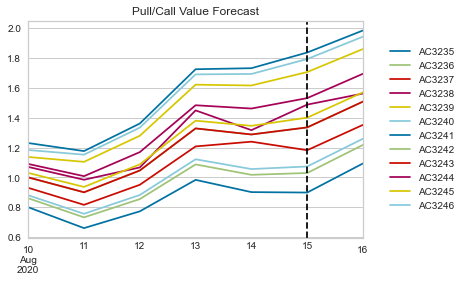

In [21]:
pt = complete_data.iloc[:,:12].plot()
plt.title("Pull/Call Value Forecast")
plt.legend(loc=5,bbox_to_anchor=(1.3, 0.5))
plt.axvline(datetime.datetime(2020, 8, 15),linestyle='--',color='black');

The values right to the dotted lines are predicted by the model i.e. "16th Aug" Values.

In [22]:
aug16.to_csv("Answer_files/file_02.csv",index=True)
#Finally The predicted values are exported as .csv file
aug16

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-16,1.093348,1.217661,1.351871,1.694194,1.859945,1.942821,1.984258,1.507725,1.507725,1.56153,...,1.217661,0.678971,0.989753,1.487006,1.528444,1.217661,0.761846,0.824003,1.072629,0.969035
